
═════════════════════════════════════════
Embedding-group CD  —  Scope: all_pooling
═════════════════════════════════════════
→ Saved per-target matrix → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_3_embedding_cd/results/per_target_matrix_all_pooling.csv


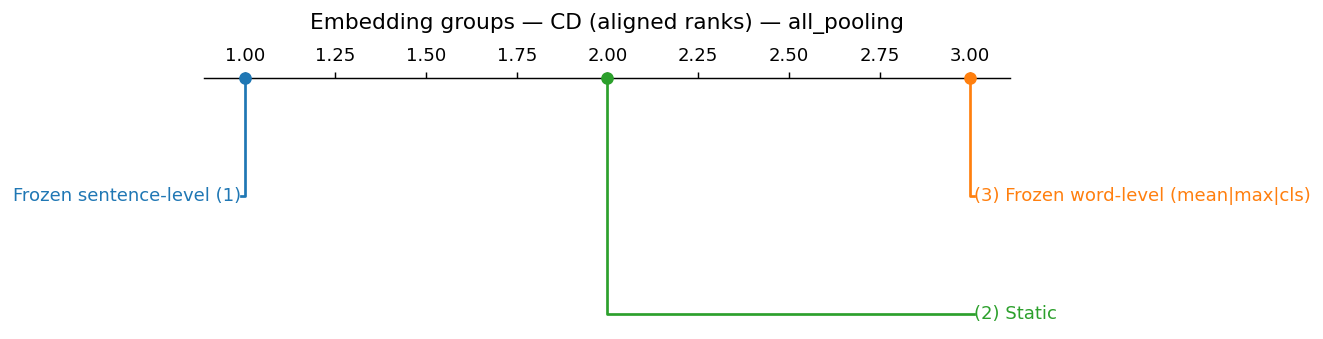

Plot saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_3_embedding_cd/plots/embedding_groups_cd_all_pooling.png

Median RRMSE per group (sorted ↑; lower is better):
Frozen sentence-level               0.811
Static                              0.882
Frozen word-level (mean|max|cls)    0.933
→ Saved sorted group medians → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_3_embedding_cd/tables/group_median_rrmse_all_pooling.csv
Nemenyi p-values (aligned ranks):
                                  Static  Frozen word-level (mean|max|cls)  Frozen sentence-level
Static                            1.0000                            0.0222                 0.0222
Frozen word-level (mean|max|cls)  0.0222                            1.0000                 0.0000
Frozen sentence-level             0.0222                            0.0000                 1.0000
  ↳ saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymou

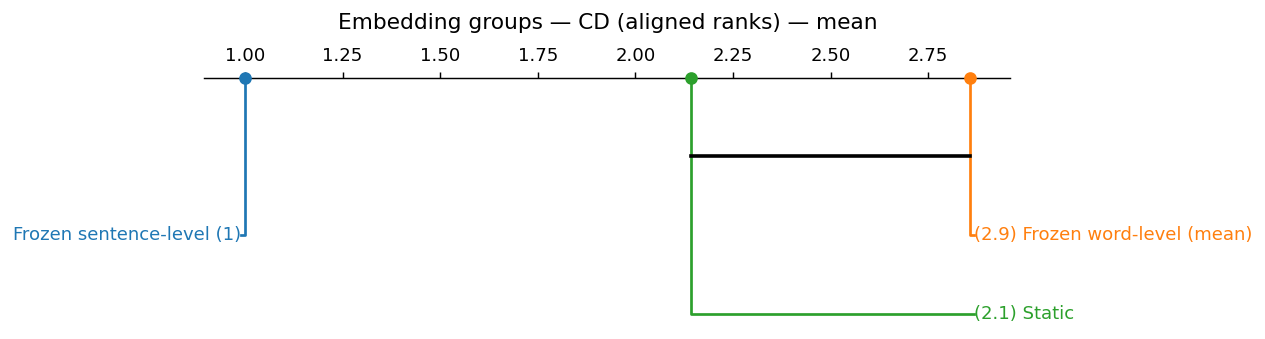

Plot saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_3_embedding_cd/plots/embedding_groups_cd_mean.png

Median RRMSE per group (sorted ↑; lower is better):
Frozen sentence-level       0.811
Static                      0.882
Frozen word-level (mean)    0.905
→ Saved sorted group medians → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_3_embedding_cd/tables/group_median_rrmse_mean.csv
Nemenyi p-values (aligned ranks):
                          Static  Frozen word-level (mean)  Frozen sentence-level
Static                    1.0000                    0.1416                  0.007
Frozen word-level (mean)  0.1416                    1.0000                  0.000
Frozen sentence-level     0.0070                    0.0000                  1.000
  ↳ saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_3_embedding_cd/tables/nemenyi_p_aligned_mean.csv

Scope 'mean' done in 0.2s

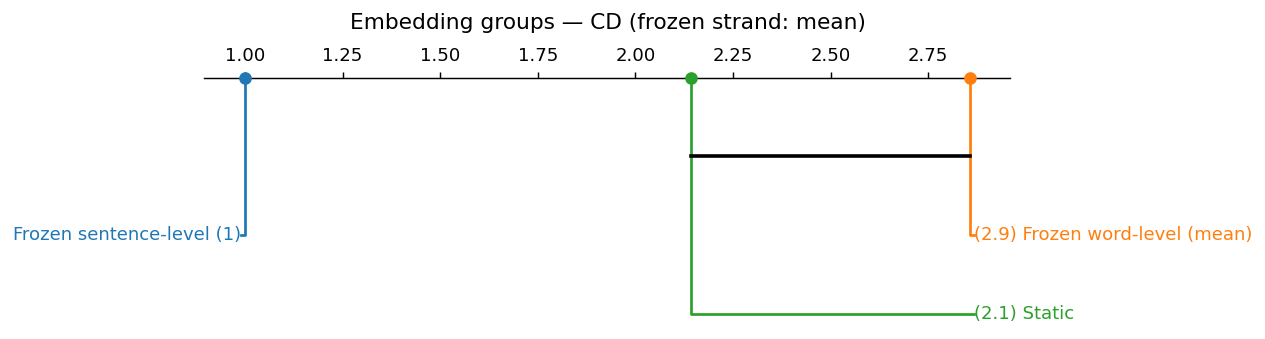

Plot saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_3_embedding_cd/plots/embedding_groups_cd_mean.png


In [1]:
"""
f_3_embedding_cd.ipynb
───────────────────────────────────────────────────────────────────────────────
Embedding-group comparison (Static vs Frozen word-level vs Frozen sentence-level)
for five selected multi-target regressors (local_lasso, local_rf, chain_ERCcv_lr,
chain_ERCcv_rf, global_rf), using LOOCV RRMSE arrays computed previously in
Step A (baseline static) and Step B (frozen transformers).

This script:

Loads per-target LOOCV RRMSE dictionaries from disk:
• Static (Step A): {word2vec, fasttext}
– tries both filename conventions:
'baseline_<emb>_loocv_rrmse.npy' and '<emb>_loocv_rrmse.npy'.
• Frozen transformers (Step B):
– Word-level pooling (mean|max|cls) on standard encoders:
{bert, robbert-v2, robbert-2023, deberta-v3, xlm-roberta-large, rembert}.
– Sentence-level encoders:
{sbert_bert, sbert_roberta, e5_base, e5_large, labse, simcse_xlmr_base}.
(Fine-tuned variants are intentionally excluded.)

Selects 5 models:
['local_lasso', 'local_rf', 'chain_ERCcv_lr', 'chain_ERCcv_rf', 'global_rf']
and builds group-wise per-target vectors by taking the median across folds,
then the median across (embeddings × selected models) within each group.

Produces two CD diagrams and full stats:
• Scope A: token-level group with mean|max|cls pooled encoders (“all_pooling”)
• Scope B: token-level group with mean-pooled encoders only (“mean”)
Also: splits token-level by pooling strand (mean/max/cls), saves strand medians,
and (optionally) renders a CD for a chosen strand via env var WORDLEVEL_STRAND.

Saves stats/tables/plots.

Inputs (LOOCV RRMSE dicts; each stores model_key -> ndarray of shape (folds, targets=14)):

- outputs/a_static/results/baseline_word2vec_loocv_rrmse.npy
or outputs/a_static/results/word2vec_loocv_rrmse.npy
- outputs/a_static/results/baseline_fasttext_loocv_rrmse.npy
or outputs/a_static/results/fasttext_loocv_rrmse.npy
- outputs/b_frozen/results/{bert_mean,bert_max,bert_cls,
robbert_v2_mean,robbert_v2_max,robbert_v2_cls,
robbert2023_mean,robbert2023_max,robbert2023_cls,
deberta_mean,deberta_max,deberta_cls,
xlmr_large_mean,xlmr_large_max,xlmr_large_cls,
rembert_mean,rembert_max,rembert_cls,
sbert_bert,sbert_roberta,e5_base,e5_large,labse,simcse_xlmr_base}_loocv_rrmse.npy

Outputs (under outputs/f_final_report/f_3_embedding_cd/):

results/
    • per_target_matrix_all_pooling.csv
    • per_target_matrix_mean.csv
    • aligned_friedman_stats_all_pooling.json
    • aligned_friedman_stats_mean.json
    • original_friedman_stats_all_pooling.json
    • original_friedman_stats_mean.json
    • included_items_/ (included combos per scope)

tables/
    • group_median_rrmse_all_pooling.csv
    • group_median_rrmse_mean.csv
    • nemenyi_p_aligned_all_pooling.csv
    • nemenyi_p_aligned_mean.csv
    • wilcoxon_raw_p_all_pooling.csv
    • wilcoxon_raw_p_mean.csv
    • wilcoxon_holm_p_all_pooling.csv
    • wilcoxon_holm_p_mean.csv
    • cliffs_delta_all_pooling.csv
    • cliffs_delta_mean.csv
    • wordlevel_strand_medians.csv

plots/
    • embedding_groups_cd_all_pooling.png
    • embedding_groups_cd_mean.png
    • (optional) embedding_groups_cd_{mean|max|cls}.png

"""

from __future__ import annotations

import os, json, time, warnings
from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare, wilcoxon
from statsmodels.stats.multitest import multipletests

np.seterr(divide="ignore", invalid="ignore")
warnings.filterwarnings("ignore", message=r"divide by zero encountered", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ─────────────────────────────────────────────────────────────────────────────
# 0) SETUP & PATHS
# ─────────────────────────────────────────────────────────────────────────────

def get_project_root(marker: str = "LICENSE") -> Path:
    cwd = Path.cwd().resolve()
    for cand in (cwd, *cwd.parents):
        if (cand / marker).is_file():
            return cand
    # Fallback to cwd (keeps runnable outside repo)
    return cwd

ROOT = get_project_root()
os.chdir(ROOT)

OUT_FINAL = ROOT / "outputs" / "f_final_report"
RES_DIR   = OUT_FINAL / "f_3_embedding_cd" / "results"
TAB_DIR   = OUT_FINAL / "f_3_embedding_cd" / "tables"
PLOT_DIR  = OUT_FINAL / "f_3_embedding_cd" / "plots"
for p in (RES_DIR, TAB_DIR, PLOT_DIR):
    p.mkdir(parents=True, exist_ok=True)

STATIC_RESULTS_IN = ROOT / "outputs" / "a_static" / "results"
FROZEN_RESULTS_IN = ROOT / "outputs" / "b_frozen" / "results"

# Selected models (keys as stored in LOOCV dictionaries) — fine-tuned excluded
SELECTED_MODELS = ["local_lasso", "local_rf", "chain_ERCcv_lr", "chain_ERCcv_rf", "global_rf"]

# Target count (Kr8cht = 14 domains/traits)
N_TARGETS = 14

# Static embedding keys & filename conventions
STATIC_KEYS = ["word2vec", "fasttext"]
STATIC_FILE_PATTERNS = [
    "baseline_{key}_loocv_rrmse.npy",
    "{key}_loocv_rrmse.npy",
]

# Sentence-level encoders (frozen)
SENTENCE_KEYS = [
    "sbert_bert",
    "sbert_roberta",
    "e5_base",
    "e5_large",
    "labse",
    "simcse_xlmr_base", 
]

# Token-level encoders (mean-only)
WORDLEVEL_KEYS_MEAN = [
    "bert_mean", "robbert_v2_mean", "robbert2023_mean",
    "deberta_mean", "xlmr_large_mean", "rembert_mean",
]

# Token-level encoders (all poolings)
WORDLEVEL_KEYS_ALL = [
    "bert_mean", "bert_max", "bert_cls",
    "robbert_v2_mean", "robbert_v2_max", "robbert_v2_cls",
    "robbert2023_mean", "robbert2023_max", "robbert2023_cls",
    "deberta_mean", "deberta_max", "deberta_cls",
    "xlmr_large_mean", "xlmr_large_max", "xlmr_large_cls",
    "rembert_mean", "rembert_max", "rembert_cls",
]

# ─────────────────────────────────────────────────────────────────────────────
# 1) HELPERS
# ─────────────────────────────────────────────────────────────────────────────

def section(title: str):
    bar = "═" * len(title)
    print(f"\n{bar}\n{title}\n{bar}")

def load_rrmse_dict_for_key(key: str) -> dict | None:
    """
    Load LOOCV RRMSE dictionary for an embedding 'key'. Tries:
      • 'baseline_<key>_loocv_rrmse.npy'
      • '<key>_loocv_rrmse.npy'
    Returns dict (model_name → (folds × targets) array) or None if not found.
    """
    base_dir = STATIC_RESULTS_IN if key in STATIC_KEYS else FROZEN_RESULTS_IN
    patterns = STATIC_FILE_PATTERNS if key in STATIC_KEYS else ["{key}_loocv_rrmse.npy"]
    for pat in patterns:
        candidate = base_dir / pat.format(key=key)
        if candidate.exists():
            try:
                return np.load(candidate, allow_pickle=True).item()
            except Exception as e:
                print(f"⚠ Failed loading {candidate.name}: {e}")
    return None

def per_target_from_rrmse(rrmse_dict: dict, model: str) -> np.ndarray | None:
    """
    Given a dict mapping model → (n_folds × n_targets) array,
    return the per-target vector (median across folds) for the specified model.
    """
    if model not in rrmse_dict:
        return None
    arr = np.asarray(rrmse_dict[model])
    if arr.ndim != 2 or arr.shape[1] != N_TARGETS:
        try:
            arr = np.array(arr)
        except Exception:
            return None
    return np.median(arr, axis=0)

def aggregate_group_vector(keys: list[str]) -> tuple[np.ndarray | None, list[str]]:
    """
    For a set of embedding 'keys', collect per-target vectors for all
    (existing_embedding, selected_model) combos and return the median across them.
    Returns:
      (vec_or_None, included_items)
    """
    per_target_stack = []
    included = []
    for emb in keys:
        rdict = load_rrmse_dict_for_key(emb)
        if rdict is None:
            continue
        for m in SELECTED_MODELS:
            v = per_target_from_rrmse(rdict, m)
            if v is not None and np.isfinite(v).all() and v.shape == (N_TARGETS,):
                per_target_stack.append(v)
                included.append(f"{emb}/{m}")
    if not per_target_stack:
        return None, []
    mat = np.vstack(per_target_stack)   # (#combos, targets)
    return np.median(mat, axis=0), included

def aligned_ranks(mat: np.ndarray) -> np.ndarray:
    """Hodges–Lehmann alignment + within-row ranking (1..k)."""
    aligned = mat - np.median(mat, axis=1, keepdims=True)
    return np.apply_along_axis(lambda r: np.argsort(np.argsort(r)) + 1, 1, aligned)

def friedman_aligned(ranks: np.ndarray) -> tuple[float, float]:
    """Return (χ²_F, F_F) for aligned Friedman given aligned ranks matrix."""
    n, k = ranks.shape
    chi2, _ = friedmanchisquare(*[ranks[:, i] for i in range(k)])
    Ff = ((n - 1) * chi2) / (n * (k - 1) - chi2)
    return chi2, Ff

def wilcoxon_matrix(mat: np.ndarray, labels: list[str]) -> pd.DataFrame:
    """Two-sided Wilcoxon (zsplit) pairwise p-values across columns."""
    df = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)
    for i, j in combinations(range(len(labels)), 2):
        d = mat[:, i] - mat[:, j]
        p = 1.0 if np.allclose(d, 0) else wilcoxon(d, zero_method="zsplit")[1]
        df.iat[i, j] = df.iat[j, i] = p
    np.fill_diagonal(df.values, 1.0)
    return df

def holm_and_cliffs(mat: np.ndarray, labels: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Holm–Bonferroni correction of Wilcoxon p-values + Cliff's Δ effect sizes.
    Returns (p_adj_df, cliffs_df) as symmetric matrices.
    """
    raw = wilcoxon_matrix(mat, labels)
    idx_pairs = list(combinations(range(len(labels)), 2))
    pvals = [raw.iat[i, j] for i, j in idx_pairs]
    _, p_adj, _, _ = multipletests(pvals, method="holm")

    adj = raw.copy()
    for (i, j), p in zip(idx_pairs, p_adj):
        adj.iat[i, j] = adj.iat[j, i] = p
    np.fill_diagonal(adj.values, 1.0)

    def cliffs_delta(x: np.ndarray, y: np.ndarray) -> float:
        diffs = np.subtract.outer(x, y)
        n = diffs.size
        return float((diffs > 0).sum() - (diffs < 0).sum()) / n

    cliffs = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)
    for i, j in idx_pairs:
        d = cliffs_delta(mat[:, i], mat[:, j])
        cliffs.iat[i, j] = d
        cliffs.iat[j, i] = -d
    np.fill_diagonal(cliffs.values, 1.0)
    return adj, cliffs

def savefig_and_show(fig, path: Path):
    fig.savefig(path, bbox_inches="tight", dpi=300)
    plt.show()
    print(f"Plot saved → {path}")

# ─────────────────────────────────────────────────────────────────────────────
# 2) RUNNER FOR ONE SCOPE
# ─────────────────────────────────────────────────────────────────────────────

def run_scope(tag: str, wordlevel_keys: list[str], wordlabel: str):
    """
    Build group vectors and run CD + stats for one scope.
    tag:             suffix for saved files (e.g., 'all_pooling' or 'mean')
    wordlevel_keys:  list of token-level embedding keys to include in the group
    wordlabel:       label for the token-level group in plots/tables
    """
    t0 = time.time()
    section(f"Embedding-group CD  —  Scope: {tag}")

    # Aggregate group vectors
    static_vec, static_inc   = aggregate_group_vector(STATIC_KEYS)
    wordlvl_vec, wordlvl_inc = aggregate_group_vector(wordlevel_keys)
    sentlvl_vec, sentlvl_inc = aggregate_group_vector(SENTENCE_KEYS)

    groups, labels = [], []
    if static_vec is not None:  groups.append(static_vec);  labels.append("Static")
    if wordlvl_vec is not None: groups.append(wordlvl_vec); labels.append(wordlabel)
    if sentlvl_vec is not None: groups.append(sentlvl_vec); labels.append("Frozen sentence-level")

    if len(groups) < 2:
        print("✖ Need at least two groups to compare. Aborting this scope.")
        return

    # Targets × groups matrix
    mat = np.column_stack(groups)  # (14, k)
    df_mat = pd.DataFrame(mat, index=[f"Target_{i+1}" for i in range(mat.shape[0])], columns=labels)
    mat_path = RES_DIR / f"per_target_matrix_{tag}.csv"
    df_mat.to_csv(mat_path)
    print(f"→ Saved per-target matrix → {mat_path}")

    # Aligned ranks + Nemenyi + CD figure
    ranks_al = aligned_ranks(mat)
    p_nem = sp.posthoc_nemenyi_friedman(ranks_al)
    if not isinstance(p_nem, pd.DataFrame):
        p_nem = pd.DataFrame(p_nem)
    p_nem.index = labels; p_nem.columns = labels
    p_clean = p_nem.fillna(1.0).copy()
    np.fill_diagonal(p_clean.values, 1.0)
    p_clean.values[:] = np.minimum(p_clean.values, p_clean.values.T)

    fig, ax = plt.subplots(figsize=(8, 2.6), dpi=130)
    sp.critical_difference_diagram(pd.Series(ranks_al.mean(0), index=labels), p_clean, ax=ax)
    ax.set_title(f"Embedding groups — CD (aligned ranks) — {tag}", pad=10)
    cd_path = PLOT_DIR / f"embedding_groups_cd_{tag}.png"
    savefig_and_show(fig, cd_path)

    # Group medians
    med_sorted = df_mat.median(axis=0).sort_values(ascending=True)
    print("\nMedian RRMSE per group (sorted ↑; lower is better):")
    print(med_sorted.round(3).to_string())
    med_path = TAB_DIR / f"group_median_rrmse_{tag}.csv"
    med_sorted.to_csv(med_path, header=["median_rrmse"])
    print(f"→ Saved sorted group medians → {med_path}")

    # Save Nemenyi p-values
    nem_path = TAB_DIR / f"nemenyi_p_aligned_{tag}.csv"
    p_nem.to_csv(nem_path)
    print("Nemenyi p-values (aligned ranks):")
    print(p_nem.round(4).to_string())
    print("  ↳ saved →", nem_path)

    # Friedman tests
    chi2_o, p_o = friedmanchisquare(*[mat[:, i] for i in range(mat.shape[1])])
    Ff_o = ((mat.shape[0] - 1) * chi2_o) / (mat.shape[0] * (mat.shape[1] - 1) - chi2_o)
    chi2_a, Ff_a = friedman_aligned(ranks_al)

    with open(RES_DIR / f"aligned_friedman_stats_{tag}.json", "w") as f:
        json.dump({"chi2_F": float(chi2_a), "F_F": float(Ff_a)}, f, indent=2)
    with open(RES_DIR / f"original_friedman_stats_{tag}.json", "w") as f:
        json.dump({"chi2_F": float(chi2_o), "p": float(p_o), "F_F": float(Ff_o)}, f, indent=2)

    # Pairwise Wilcoxon + Holm + Cliff's Δ
    wilc = wilcoxon_matrix(mat, labels)
    wilc_path = TAB_DIR / f"wilcoxon_raw_p_{tag}.csv"
    wilc.to_csv(wilc_path)

    adj, cliffs = holm_and_cliffs(mat, labels)
    adj_path = TAB_DIR / f"wilcoxon_holm_p_{tag}.csv"
    cliffs_path = TAB_DIR / f"cliffs_delta_{tag}.csv"
    adj.to_csv(adj_path)
    cliffs.to_csv(cliffs_path)

    # Included items (save lists)
    inc_dir = RES_DIR / f"included_items_{tag}"
    inc_dir.mkdir(parents=True, exist_ok=True)
    if static_inc:   (inc_dir / "static.txt").write_text("\n".join(static_inc), encoding="utf-8")
    if wordlvl_inc:  (inc_dir / "wordlevel.txt").write_text("\n".join(wordlvl_inc), encoding="utf-8")
    if sentlvl_inc:  (inc_dir / "sentence.txt").write_text("\n".join(sentlvl_inc), encoding="utf-8")

    print(f"\nScope '{tag}' done in {time.time() - t0:.1f}s.")

# ─────────────────────────────────────────────────────────────────────────────
# 3) STRAND BREAKDOWN (+ optional per-strand CD)
# ─────────────────────────────────────────────────────────────────────────────

def write_wordlevel_strand_medians_and_optional_cd():
    all_keys = [
        "bert_mean","bert_max","bert_cls",
        "robbert_v2_mean","robbert_v2_max","robbert_v2_cls",
        "robbert2023_mean","robbert2023_max","robbert2023_cls",
        "deberta_mean","deberta_max","deberta_cls",
        "xlmr_large_mean","xlmr_large_max","xlmr_large_cls",
        "rembert_mean","rembert_max","rembert_cls",
    ]
    mean_keys = [k for k in all_keys if k.endswith("mean")]
    max_keys  = [k for k in all_keys if k.endswith("max")]
    cls_keys  = [k for k in all_keys if k.endswith("cls")]

    rows = []
    for strand, keys in [("mean", mean_keys), ("max", max_keys), ("cls", cls_keys)]:
        vec, included = aggregate_group_vector(keys)
        rows.append({
            "strand": strand,
            "n_items": int(len(included)),
            "median_rrmse": (float(np.median(vec)) if vec is not None else np.nan)
        })
    strand_df = pd.DataFrame(rows).sort_values("median_rrmse", ascending=True, na_position="last")
    out = TAB_DIR / "wordlevel_strand_medians.csv"
    strand_df.to_csv(out, index=False)
    print("→ Saved strand medians →", out)

    # Optional per-strand CD (Static vs chosen word-strand vs Sentence)
    strand = os.getenv("WORDLEVEL_STRAND", "mean").strip().lower()
    do_cd  = os.getenv("SAVE_STRAND_CD", "1").lower() in {"1","true","yes"}
    pool_map = {"mean": mean_keys, "max": max_keys, "cls": cls_keys}
    if do_cd and strand in pool_map:
        static_vec, _ = aggregate_group_vector(STATIC_KEYS)
        word_vec, _   = aggregate_group_vector(pool_map[strand])
        sent_vec, _   = aggregate_group_vector(SENTENCE_KEYS)
        labels, groups = [], []
        if static_vec is not None: labels.append("Static"); groups.append(static_vec)
        if word_vec is not None:   labels.append(f"Frozen word-level ({strand})"); groups.append(word_vec)
        if sent_vec is not None:   labels.append("Frozen sentence-level"); groups.append(sent_vec)
        if len(groups) >= 2:
            mat = np.column_stack(groups)
            ranks_al = aligned_ranks(mat)
            p_nem = sp.posthoc_nemenyi_friedman(ranks_al)
            if not isinstance(p_nem, pd.DataFrame):
                p_nem = pd.DataFrame(p_nem)
            p_nem.index = labels; p_nem.columns = labels
            p_clean = p_nem.fillna(1.0).copy()
            np.fill_diagonal(p_clean.values, 1.0)
            p_clean.values[:] = np.minimum(p_clean.values, p_clean.values.T)
            fig, ax = plt.subplots(figsize=(8, 2.6), dpi=130)
            sp.critical_difference_diagram(pd.Series(ranks_al.mean(0), index=labels), p_clean, ax=ax)
            ax.set_title(f"Embedding groups — CD (frozen strand: {strand})", pad=10)
            outp = PLOT_DIR / f"embedding_groups_cd_{strand}.png"
            savefig_and_show(fig, outp)

# ─────────────────────────────────────────────────────────────────────────────
# 4) ENTRY POINT — run both scopes and strand summary
# ─────────────────────────────────────────────────────────────────────────────

if __name__ == "__main__":
    # Scope A: all poolings in the token-level group
    run_scope(
        tag="all_pooling",
        wordlevel_keys=WORDLEVEL_KEYS_ALL,
        wordlabel="Frozen word-level (mean|max|cls)"
    )

    # Scope B: mean pooling only for the token-level group
    run_scope(
        tag="mean",
        wordlevel_keys=WORDLEVEL_KEYS_MEAN,
        wordlabel="Frozen word-level (mean)"
    )

    # Strand breakdown table (+ optional per-strand CD figure)
    write_wordlevel_strand_medians_and_optional_cd()
